<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1">Background</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Setup-the-workspace" data-toc-modified-id="Setup-the-workspace-1.0.1">Setup the workspace</a></span></li></ul></li></ul></li><li><span><a href="#Motivation" data-toc-modified-id="Motivation-2">Motivation</a></span><ul class="toc-item"><li><span><a href="#Source-and-clean-my-results-from-the-event-here" data-toc-modified-id="Source-and-clean-my-results-from-the-event-here-2.1">Source and clean my results from the event <a href="https://hyrox.r.mikatiming.com/season-4/?content=detail&amp;fpid=list&amp;pid=list&amp;idp=2EFMS4JI288F0&amp;lang=EN_CAP&amp;event=H_2EFMS4JI2BD&amp;page=2&amp;pidp=start&amp;ranking=time_finish_netto&amp;search%5Bsex%5D=M&amp;search%5Bage_class%5D=%25&amp;search%5Bnation%5D=%25&amp;search_event=H_2EFMS4JI2BD" rel="nofollow" target="_blank">here</a></a></span></li><li><span><a href="#Sense-check-the-results" data-toc-modified-id="Sense-check-the-results-2.2">Sense check the results</a></span></li></ul></li><li><span><a href="#Station-simulation" data-toc-modified-id="Station-simulation-3">Station simulation</a></span><ul class="toc-item"><li><span><a href="#1.-Simulating-the-run-(8x1km)" data-toc-modified-id="1.-Simulating-the-run-(8x1km)-3.1">1. Simulating the run (8x1km)</a></span></li><li><span><a href="#2.-Ski-erg" data-toc-modified-id="2.-Ski-erg-3.2">2. Ski-erg</a></span></li></ul></li></ul></div>

# Background
On January 29 2022, I competed in a functional fitness race called [HYROX](https://hyrox.com/en/) in Manchester, UK. The event consists of running and functional fitness stations, more precisely:
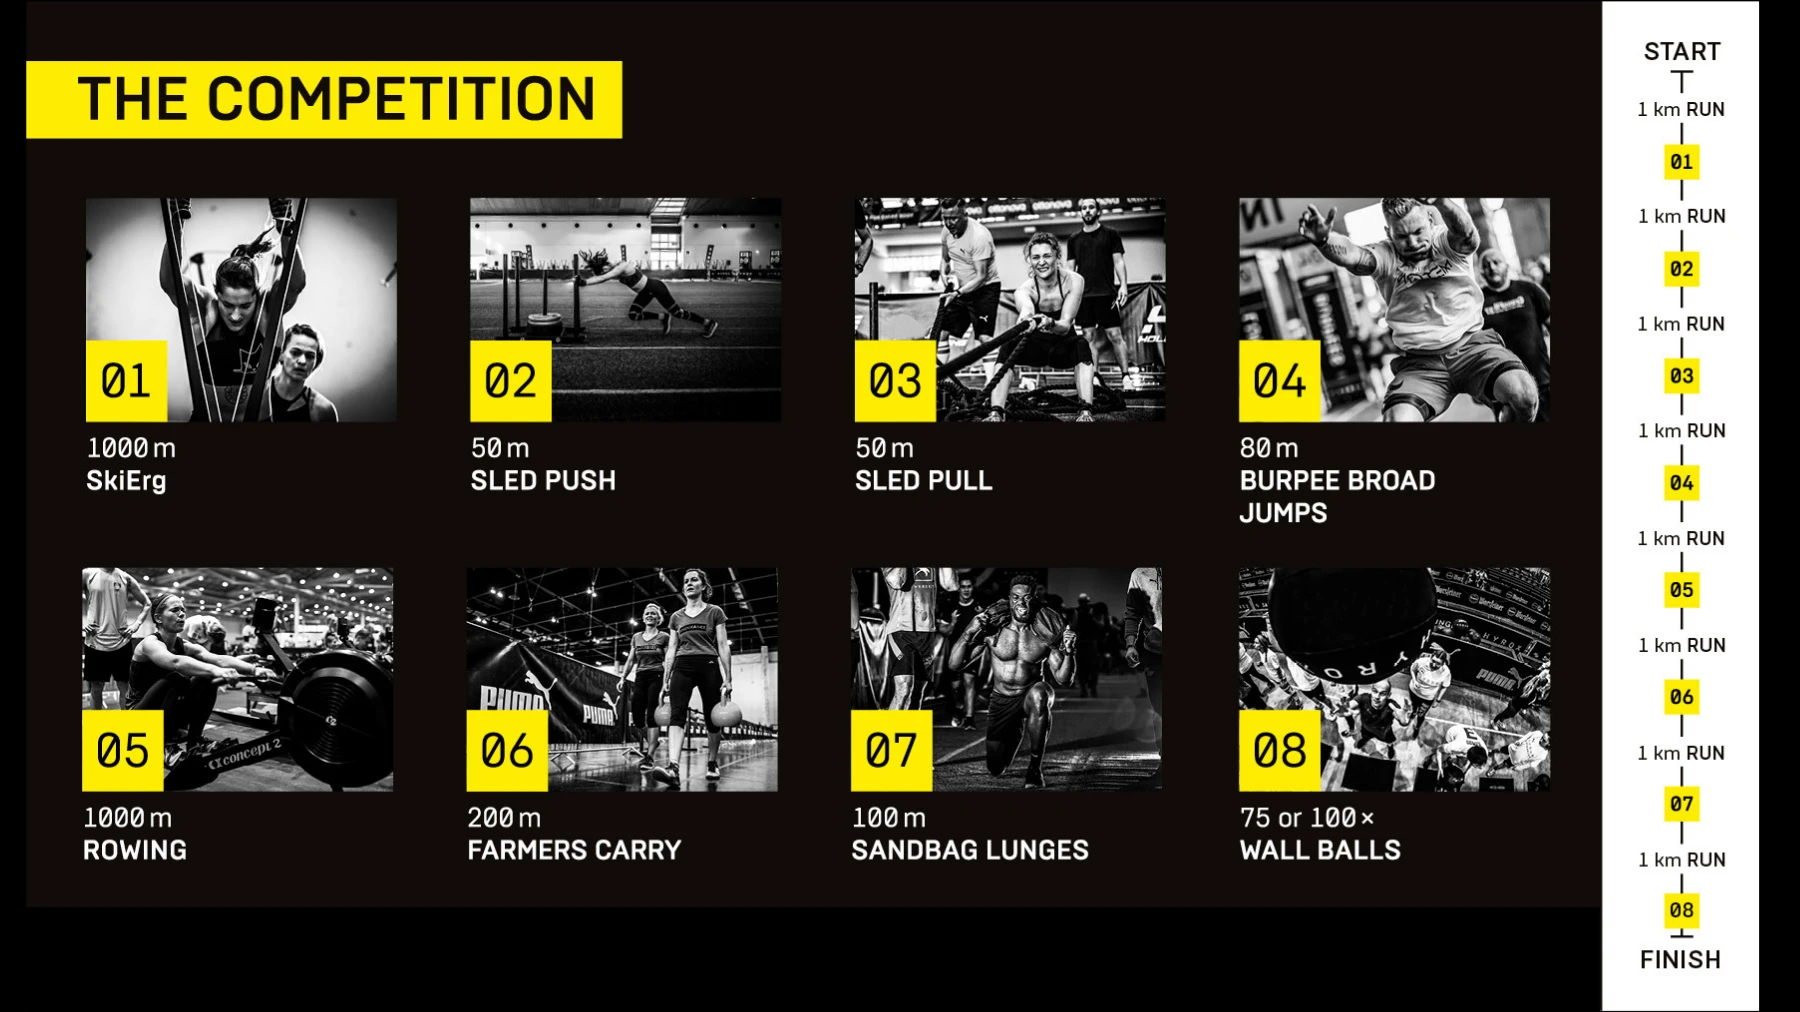

Having been informed that the average finishing time for athletes in the event was around 90 minutes, I went into the event not expecting too much of myself, so I was targeting a finish time of around 80-85 minutes, as I had done some training before.

I was pleasantly surprised to finish the event in 1.09.56, finishing 27th overall man (out of 478 athletes). This was fast enough to qualify for the World Championships in Las Vegas in May. I'm intrigued whether I can improve on that time, and if so by how much. Given my background in Data Science/Mathematics, I thought it would be a good idea to simulate the race to see how much time (mathematically) I can make up.



### Setup the workspace

In [1]:
# Created on: 08 Feb 2022
# Created by: Philip P
# Script to get current HYROX results and simulate some finish times to see how much 
# time I could make up
import os
import re

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(100)

# Motivation
I'm curious to see if I can model hundreds/thousands of HYROX event simulations using my expected finishing times. I will aim to do this by sampling randomly from different distributions I see fit for each station in the event.

(Note this is a pet project and doesn't carry scientific significance, nor are any of the assumptions well-founded.)

## Source and clean my results from the event [here](https://hyrox.r.mikatiming.com/season-4/?content=detail&fpid=list&pid=list&idp=2EFMS4JI288F0&lang=EN_CAP&event=H_2EFMS4JI2BD&page=2&pidp=start&ranking=time_finish_netto&search%5Bsex%5D=M&search%5Bage_class%5D=%25&search%5Bnation%5D=%25&search_event=H_2EFMS4JI2BD )
Go onto the HYROX website to find the results from the overall event, and the individual times for each leg. Once these results have been retrieved, I will clean them into a common format for time (seconds).

In [2]:
run_legs = {
    1: 3.55, 2: 4.10, 3: 4.32, 4: 4.18,
    5: 4.20, 6: 4.21, 7: 4.08, 8: 4.34  
}
functional_stations = {
    'ski_erg': 4.35,
    'sled_push': 2.13,
    'sled_pull': 3.48,
    'burpee': 3.59,
    'row': 4.27,
    'carry': 2.06,
    'lunges': 4.21,
    'wall_balls': 5.23
}
rock_zone = 4.59

Convert to seconds

In [3]:
functional_station_s = {
    k: 60*int(functional_stations[k]) + 100*(functional_stations[k] % 1) 
    for k, v in functional_stations.items()}

run_legs_s = [60*int(k) + 100*(k % 1) for k in run_legs.values()] # 60 * int(k)

Check the conversion

In [4]:
functional_station_s

{'ski_erg': 274.99999999999994,
 'sled_push': 133.0,
 'sled_pull': 228.0,
 'burpee': 239.0,
 'row': 266.99999999999994,
 'carry': 126.0,
 'lunges': 261.0,
 'wall_balls': 323.00000000000006}

In [5]:
run_legs_s

[235.0, 249.99999999999997, 272.0, 258.0, 260.0, 261.0, 248.0, 274.0]

These look ok!

## Plotting function
Generic plotting function for the random samples

In [6]:
def plot_results(times_vector: np.ndarray,
                station: str) -> None:
    """Helper method to plot the sample times from the normal distribution."""
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        x=times_vector,
        whis=[0, 100], width=.6, palette="vlag")

    # Add in points to show each observation
    sns.stripplot(x=times_vector,
                  size=4, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    plt.xlabel(f'Station: {station} time (s)')
    plt.title(f"Box plot of station: {station} sample times")

## Sense check the results
We will visualise some of the results to ensure they make sense.

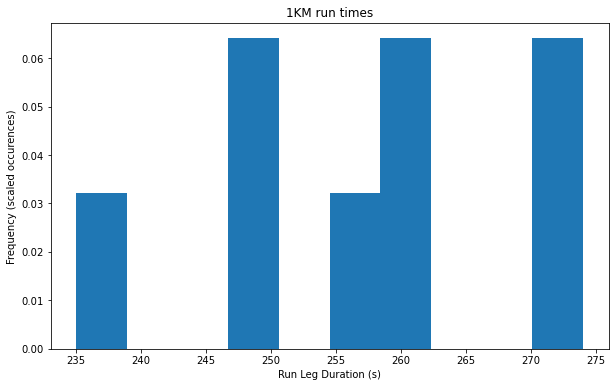

In [7]:
plt.figure(figsize=(10,6))
plt.hist(run_legs_s,
        density=True)
plt.xlabel("Run Leg Duration (s)")
plt.ylabel("Frequency (scaled occurences)")
plt.title("1KM run times")
plt.show()

These look quite sensible, seems like the average time was around 255s (4m15s), with the minimum being just under 4 mins (3.55), and maximum just over 4.5 mins (4.34).

# Station simulation
Now we will simulate each part of the event, using some distributions and the previous results, as well as my experience to give an idea of what times are realistic.

In [8]:
# set the number of simulations
n_sims = 1000

## 1. Simulating the run (8x1km)

Generate some random samples from the same (normal) distribution to get random times for the simulation

In [9]:
num_samples = 1000
results_describe = pd.Series(run_legs_s).describe()

run_1k_times = np.random.normal(loc=results_describe['mean'],
                                scale=results_describe['std'],
                                size=num_samples)

In [10]:
print(f"From just 8 samples of the 1k run, we have the summary statistics \n"
      f"average time = {results_describe['mean']: .2f}s \n"
      f"standard deviation = {results_describe['std'] : .2f}s \n")

low_bound = results_describe['mean'] - 2*results_describe['std']
high_bound = results_describe['mean'] + 2*results_describe['std']

print("Given the normal distribution, mathematically two standard deviations "
      "from the mean would bound 95% of all results. In this case, we'd expect 95% of "
      f"the run times to be in the range {low_bound:.1f}-{high_bound :.1f}s")

From just 8 samples of the 1k run, we have the summary statistics 
average time =  257.25s 
standard deviation =  12.84s 

Given the normal distribution, mathematically two standard deviations from the mean would bound 95% of all results. In this case, we'd expect 95% of the run times to be in the range 231.6-282.9s


Inspect the normally distributed times to check they are realistic.

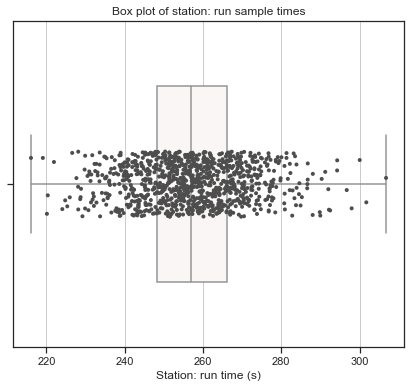

In [11]:
plot_results(times_vector=run_1k_times,
             station='run')

These times look quite realistic, with a cluster around 260s (4m20s), and the minimum time being less than 220s (3m40s), and maximum around 310s (5m10s). I'm not sure how realistic these are in terms of range, I think the times perhaps could be more tight in the next event.

Decrease the standard deviation for the next iteration.

In [12]:
sample_1k_times = np.random.normal(
    loc=results_describe['mean'],
    scale=0.75*results_describe['std'],
    size=num_samples)

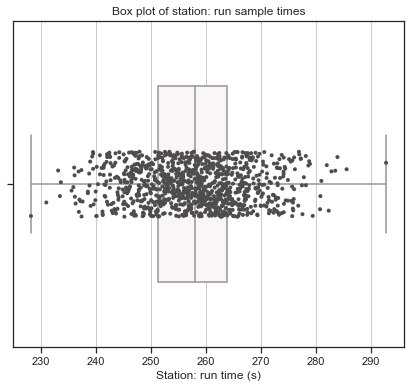

In [13]:
plot_results(times_vector=sample_1k_times,
            station='run')

This probably looks a little more realistic, with the quickest lap being around 230s (3m50s), which is definitely realistic for an event (especially if one lap is shorter than the rest). The slowest lap being around 285s (4m45s) is also realistic, with the adrenaline definitely not allowing me to go slower than this.

Let's take these metrics going forward for the simulation, therefore we will sum all of the 8 individual records for each kilometre to get a total run time.

In [14]:
simulated_run_legs = np.random.normal(
    loc=results_describe['mean'],
    scale=0.75*results_describe['std'],
    size=(n_sims, 8))

Let's look at the first sample of run legs

In [15]:
simulated_run_legs[1,:]

array([256.7591903 , 251.24055584, 262.03840491, 250.52509584,
       255.81506903, 251.04106997, 243.60163563, 251.34146058])

These look ok, now let's sum the times. We can use the previous function to plot the total run times and get an idea of the estimated overall run times.

In [16]:
simulated_run_times = simulated_run_legs.sum(axis=1)

Text(0.5, 0, 'Total run time for all legs (mins)')

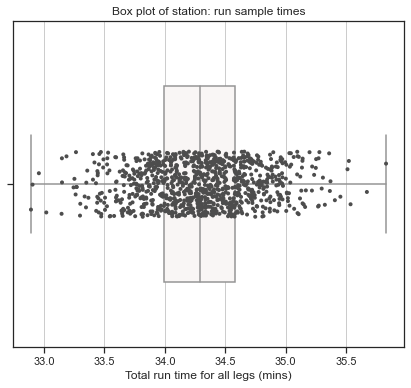

In [17]:
plot_results(times_vector=simulated_run_times/60,
            station='run')
# adjust the title as it's not correct
plt.xlabel("Total run time for all legs (mins)")

I think this looks quite realistic. Lots of training would probably lead to faster 8k time overall, but factoring in the tiredness between stations, fatigue, overtaking people etc. This looks ok for now!

## 2. Ski-erg
Now we will simulate the ski-erg station. In the past, this hasn't been my strongest erg, but given that it is at the beginning of the event, it's quite key to not go too hard, else one would spike the heart rate and therefore make it more difficult for themselves for the rest of the event.

In [18]:
print(f"Ski erg time: {functional_station_s['ski_erg']:.1f}s")

Ski erg time: 275.0s


This time looks a bit slow, I'd hope that the overall time in the next event will be faster, with the fastest time to do it in 4 minutes, and slowest around 4.40. Let's sample from a uniform distribution to get these times.

In [19]:
simulated_ski_times = np.random.uniform(low=240, high=280, size=n_sims)

Plot some of the results from the uniform distribution to see if it makes sense.

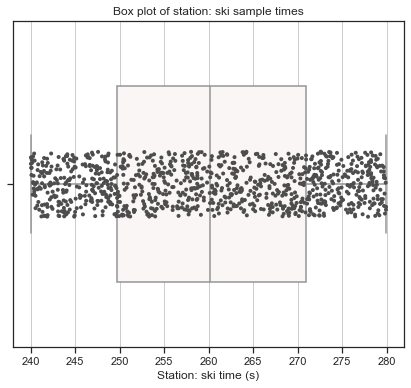

In [20]:
plot_results(times_vector=simulated_ski_times,
             station='ski')

Looks good! Onto the next station.